---
# Part 2, Figure 3
Graphic for oil spill fate by "location category", i.e. water column, water surface, beach, and air (evaporation)

---

This code requires output from code run on Compute Canada's HPC. For the purpose of this publication, this code has been placed in `../scripts/HPC_scripts/HPC_aggregate_mass_balance.py`

## Environment Setup

Install required packages using the provided environment file:
```bash
conda env create -f ../environment.yaml
conda activate midoss_env
```

*Ensure the dataset and code repositories are in the same root folder:*
```
root_folder/
├── MuellerEtAl_MIDOSS_datasets/
└── MuellerEtAl_MIDOSS_code/   # (this repository)
```

`MuellerEtAl_MIDOSS_datasets` is the companion [FRDR data repository](https://doi.org/10.20383/103.01353)

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import yaml
import timeß

### Directory paths and file names

In [2]:
# graphics style
plt.style.use(r"../graphics_utils/style.template")

# predefined naming conventions
sys.path.append('../graphics_utils/')
import graphics_setup as graphics

# directories
aggregated_spills_dir =Path('../../MuellerEtAl_MIDOSS_datasets/aggregated_spills_output')
graphics_dir = Path('..')
spills_csv_dir = Path(
    '../../MuellerEtAl_MIDOSS_datasets/spill_files'
)
spill_init=pd.read_csv(spills_csv_dir/'SalishSea_oil_spills_4.csv')

# created with ../scripts/HPC_scripts/HPC_aggregate_mass_balance.py
input_file_oil = aggregated_spills_dir/'massbalance_byoil_16062022_03:20:07.yaml'

### Open existing mass aggregation file

In [3]:
 with open(input_file_oil) as file:
     sro = yaml.safe_load(file)

In [4]:
df={}
df['ANS'] = pd.DataFrame(sro['ANS'])
df['Bunker-C'] = pd.DataFrame(sro['Bunker-C'])
df['Diesel'] = pd.DataFrame(sro['Diesel'])
df['Dilbit'] = pd.DataFrame(sro['Dilbit'])

### calculate geometric mean of mass values
- total (MEvaporated + MDispersed + MDissolved + MBio + MSurface + MBeached)
- surface (MassOil)
- beached (MBeached)
- water column (MDispersed, MDissolved, MBio)

In [5]:
# specify key words
oil_types = ['ANS', 'Bunker-C', 'Diesel', 'Dilbit']
#oil_types = ['ANS', 'Bunker-C', 'Diesel']
locations = ['water','sfc','beach','air']
# initialize dictionaries
water = {}
sfc = {}
beach = {}
air = {}
time={}
initial={}
final={}
tmp={}
mass_max = {}
combined_mass = {}
total_mass = {}
# create dictionary of mean values (update code later to use this method for geometric mean values!)
mean = {}
for location in locations:
    mean[location] = {}
    final[location]={}
    for oil in oil_types:
        final[location][oil]=[]
# cataloge information by oil type
for oil in oil_types:
    print(oil)
    # number of spills with positive dissolution (note: for Bunker but applied to all)
    Nspills = len(df[oil]['MDissolved'].loc[df[oil]['MDissolved']>0])
    water_col = (df[oil]['MDispersed'].loc[df[oil]['MDissolved']>0] + 
        df[oil]['MDissolved'].loc[df[oil]['MDissolved']>0] + 
        df[oil]['MBio'].loc[df[oil]['MDissolved']>0])
    # remove values associated with bogus dissolution/evaporation/surface
    surface = df[oil]['MassOil'].loc[df[oil]['MDissolved']>0]
    beached = df[oil]['MBeached'].loc[df[oil]['MDissolved']>0]
    evaporated = df[oil]['MEvaporated'].loc[df[oil]['MDissolved']>0]
    # get vectors of spill duration 
    time[oil]=df[oil]['days_since_spill'].loc[df[oil]['MDissolved']>0]
    # calculate geometric means
    water[oil]=np.exp(np.log(water_col.loc[water_col>0]).sum()/ Nspills)
    sfc[oil]=np.exp(np.log(surface.loc[surface>0]).sum()/ Nspills)
    beach[oil]=np.exp(np.log(beached.loc[beached>0]).sum()/ Nspills)
    air[oil]=np.exp(np.log(evaporated.loc[evaporated>0]).sum()/ Nspills)
    # Add up total, initial oil mass
    initial[oil]=df[oil]['MInitial'].loc[df[oil]['MDissolved']>0]
    # Save array of final, total oil mass for all runs
    final['water'][oil]=water_col
    final['sfc'][oil]=surface
    final['beach'][oil]=beached
    final['air'][oil]=evaporated
    # calculate means
    mean['water'][oil] = water_col.sum()/ Nspills
    mean['sfc'][oil] = surface.sum()/ Nspills
    mean['beach'][oil] = beached.sum()/ Nspills
    mean['air'][oil] = evaporated.sum()/Nspills
    # all but evaporation
    combined_mass[oil] = water_col.sum() + surface.sum() + beached.sum()
    total_mass[oil] = combined_mass[oil] + evaporated.sum()

ANS
Bunker-C
Diesel
Dilbit


## Evaluate spills that are included in this analysis

### spill duration and number of spills

In [6]:
print('*** Spill duration and [number of spills] included in analysis ***') 
for oilname in [*time]:
    print(f'{oilname}: {np.median(time[oilname]):2.2f}, {np.min(time[oilname]):2.2f}, {np.mean(time[oilname]):2.2f} [{len(time[oilname])}]')

*** Spill duration and [number of spills] included in analysis ***
ANS: 7.00, 0.79, 6.60 [64]
Bunker-C: 7.00, 0.04, 5.08 [3416]
Diesel: 3.38, 0.08, 3.94 [6352]
Dilbit: 1.21, 1.21, 1.21 [1]


### verify number of spills in input dictionary

In [7]:
total=0
for oilname in [*sro]:
    print(f'{oilname}: {len(sro[oilname]["MassOil"])} spills')
    total+=len(sro[oilname]["MassOil"])
print('---------------')
print(f'TOTAL: {total}')

ANS: 64 spills
Bunker-C: 3416 spills
Diesel: 6352 spills
Dilbit: 1 spills
---------------
TOTAL: 9833


### Extract information from the monte carlo spills file used to run the MOHID model

In [8]:
# define names used for Lagrangian files
oil_template_names = [
    'Lagrangian_akns.dat','Lagrangian_bunker.dat',
     'Lagrangian_diesel.dat','Lagrangian_gas.dat',
     'Lagrangian_jet.dat','Lagrangian_dilbit.dat',
     'Lagrangian_other.dat'
]
# define desired, end-product names for oil-types
oil_types_7 = [
    'ANS','Bunker-C',
    'Diesel','Diesel',
    'Diesel','Dilbit', 
    'Bunker-C'
]

# replace Lagrangian template file names with oil type tags
spill_init['oil_type'] = spill_init['Lagrangian_template'].replace(
    oil_template_names, 
    oil_types_7
)
# volume of spills by oil type (converted to megaliters)
volume = dict(spill_init.groupby('oil_type').spill_volume.sum()/1e6)
volume_max = dict(spill_init.groupby('oil_type').spill_volume.max()/1e6)
# number of spills by oil type
number_spills=dict(spill_init[['oil_type','spill_date_hour']].groupby('oil_type').count().rename(columns={'spill_date_hour':'N spills'}))
# geometric mean of spills
spill_init['spill_volume_ln'] = np.log(spill_init['spill_volume'])
geomean = dict(np.exp(spill_init.groupby('oil_type').spill_volume_ln.sum()/number_spills['N spills'])/1e6)

## Plot results

In [9]:
# remove dilbit
geomean.pop('Dilbit')
volume.pop('Dilbit')
volume_max.pop('Dilbit')
water.pop('Dilbit')
sfc.pop('Dilbit')
beach.pop('Dilbit')
combined_mass.pop('Dilbit')
total_mass.pop('Dilbit')

np.float64(1142441.0483756834)

## Create metric for demonstrating persistence

#### initial
- MBeached = (data['VolOilBeached'][1].item()*data['Density'][1].item()/
     (1-data['VWaterContent'][1].item())*
     (1-data['MWaterContent'][1].item()))
- MInitial= data['MEvaporated'][1].item() + data['MDispersed'][1].item() + 
    data['MDissolved'][1].item() + data['MBio'][1].item() + 
    data['MassOil'][1].item() + MBeached
#### final (remove values associated with bogus dissolution/evaporation/surface)
- water_col = (df[oil]['MDispersed'].loc[df[oil]['MDissolved']>0] + 
        df[oil]['MDissolved'].loc[df[oil]['MDissolved']>0] + 
        df[oil]['MBio'].loc[df[oil]['MDissolved']>0])
    
    surface = df[oil]['MassOil'].loc[df[oil]['MDissolved']>0]
    beached = df[oil]['MBeached'].loc[df[oil]['MDissolved']>0]
    evaporated = df[oil]['MEvaporated'].loc[df[oil]['MDissolved']>0] 

#### Print out persist values for debugging

In [10]:
# median value of the final mass (by category) over initial spill
locations = ['water','sfc','beach','air']
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
for oil in ['ANS','Bunker-C','Diesel']:
    print('~~~~~~')
    print(f'{oil} [{len(final["sfc"][oil])}]')
    print('~~~~~~')
    for location in locations:
        print(f'*** {location} ***')
        pers_tmp = final[location][oil]/(initial[oil])
        print(pers_tmp.loc[pers_tmp>=1])
    

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~
ANS [64]
~~~~~~
*** water ***
Series([], dtype: float64)
*** sfc ***
Series([], dtype: float64)
*** beach ***
Series([], dtype: float64)
*** air ***
Series([], dtype: float64)
~~~~~~
Bunker-C [3416]
~~~~~~
*** water ***
Series([], dtype: float64)
*** sfc ***
Series([], dtype: float64)
*** beach ***
12      1.000278
36      1.001835
54      1.000715
59      1.000048
105     1.001154
          ...   
3350    1.000087
3358    1.000458
3372    1.000036
3411    1.000062
3412    1.000236
Length: 129, dtype: float64
*** air ***
Series([], dtype: float64)
~~~~~~
Diesel [6352]
~~~~~~
*** water ***
Series([], dtype: float64)
*** sfc ***
Series([], dtype: float64)
*** beach ***
Series([], dtype: float64)
*** air ***
Series([], dtype: float64)


#### take-away: Bunker beaching values are wonky.  Perhaps a reflection of the evaporation error that is now fixed.  

### Create dataframes of values for:
- median
- mean
- stdev
- min
- max
- quantiles (0.25, 0.50, 0.75)

In [11]:
locations = ['water','sfc','beach','air']
opperations = ['median','mean','std','min','max']
job='median'
getattr(np, job)([0, 2, 3])
#np.median([0, 2, 3])
persist = {}

# Calculate Quantiles
persist['Q1']={}
persist['Q2']={}
persist['Q3']={}
for oil in ['ANS','Bunker-C','Diesel']:
    persist['Q1'][oil]={}
    persist['Q2'][oil]={}
    persist['Q3'][oil]={}
    for loc in locations:
        #Quantile 0.25 (in percent form)
        persist['Q1'][oil][loc]=100*np.quantile(
            final[loc][oil]/(initial[oil]), .25)
        #Quantile 0.5 (median, in percent form)
        persist['Q2'][oil][loc]=100*np.quantile(
            final[loc][oil]/(initial[oil]), .50)
        #Quantile 0.75 (in percent form)
        persist['Q3'][oil][loc]=100*np.quantile(
            final[loc][oil]/(initial[oil]), .75)

# Calculate other stats across persistence fractions
print('Calculating the following stats across persistence fraction')
for opp in opperations:
    print("|_", opp)
    persist[opp]={}  
    for oil in ['ANS','Bunker-C','Diesel']:
        print("    |_", oil)
        persist[opp][oil]={}
        for loc in locations:
            print("        |_", loc)
            # final mass (by category) over initial spill
            persist[opp][oil][loc]=getattr(np, opp)(
                100*final[loc][oil]/(initial[oil])
            )
# Add Quantiles to opperations
opperations = ['median','mean','std','min','max','Q1','Q2','Q3']
persist_df={}
print('-------------------')
print('BUILDING DATAFRAMES')
print('-------------------')
for opp in opperations:
#    print('\n\n \_ ', opp)
    persist_df[opp] = pd.DataFrame({
        "ANS":[persist[opp]["ANS"]["water"], persist[opp]["ANS"]["sfc"], persist[opp]["ANS"]["beach"], persist[opp]["ANS"]["air"]],
        "Bunker-C":[persist[opp]["Bunker-C"]["water"], persist[opp]["Bunker-C"]["sfc"], persist[opp]["Bunker-C"]["beach"], persist[opp]["Bunker-C"]["air"]],
        "Diesel":[persist[opp]["Diesel"]["water"], persist[opp]["Diesel"]["sfc"], persist[opp]["Diesel"]["beach"], persist[opp]["Diesel"]["air"]]
        }, 
        index=["water", "surface", "beach", "air"]
    )
    persist_df[opp] = persist_df[opp].rename_axis(opp, axis=1)
 #   print(persist_df[opp])   

Calculating the following stats across persistence fraction
|_ median
    |_ ANS
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Bunker-C
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Diesel
        |_ water
        |_ sfc
        |_ beach
        |_ air
|_ mean
    |_ ANS
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Bunker-C
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Diesel
        |_ water
        |_ sfc
        |_ beach
        |_ air
|_ std
    |_ ANS
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Bunker-C
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Diesel
        |_ water
        |_ sfc
        |_ beach
        |_ air
|_ min
    |_ ANS
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Bunker-C
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Diesel
        |_ water
        |_ sfc
        

In [12]:
plotdata = pd.DataFrame({
    "ANS":[persist['median']["ANS"]["water"], persist['median']["ANS"]["sfc"], persist['median']["ANS"]["beach"], persist['median']["ANS"]["air"]],
    "Bunker-C":[persist['median']["Bunker-C"]["water"], persist['median']["Bunker-C"]["sfc"], persist['median']["Bunker-C"]["beach"], persist['median']["Bunker-C"]["air"]],
    "Diesel":[persist['median']["Diesel"]["water"], persist['median']["Diesel"]["sfc"], persist['median']["Diesel"]["beach"], persist['median']["Diesel"]["air"]]
    }, 
    index=["water\ncolumn", "water\nsurface", "beach", "air"]
)
plotdata

,ANS,Bunker-C,Diesel
water\ncolumn,0.036296,0.000102,0.097653
water\nsurface,0.655659,0.367823,0.074312
beach,78.109184,96.020866,67.812072
air,19.317904,1.163776,29.985719


In [13]:
persist_df['median']

median,ANS,Bunker-C,Diesel
water,0.036296,0.000102,0.097653
surface,0.655659,0.367823,0.074312
beach,78.109184,96.020866,67.812072
air,19.317904,1.163776,29.985719


### create error bars from Quantiles

In [14]:
error_min = [[persist['Q1']["ANS"]["water"],persist['Q1']["ANS"]["sfc"],persist['Q1']["ANS"]["beach"],persist['Q1']["ANS"]["air"]],
         [persist['Q1']["Bunker-C"]["water"],persist['Q1']["Bunker-C"]["sfc"],persist['Q1']["Bunker-C"]["beach"],persist['Q1']["Bunker-C"]["air"]],
         [persist['Q1']["Diesel"]["water"],persist['Q1']["Diesel"]["sfc"],persist['Q1']["Diesel"]["beach"],persist['Q1']["Diesel"]["air"]]
]

error_max = [[persist['Q3']["ANS"]["water"],persist['Q3']["ANS"]["sfc"],persist['Q3']["ANS"]["beach"],persist['Q3']["ANS"]["air"]],
         [persist['Q3']["Bunker-C"]["water"],persist['Q3']["Bunker-C"]["sfc"],persist['Q3']["Bunker-C"]["beach"],persist['Q3']["Bunker-C"]["air"]],
         [persist['Q3']["Diesel"]["water"],persist['Q3']["Diesel"]["sfc"],persist['Q3']["Diesel"]["beach"],persist['Q3']["Diesel"]["air"]]
]
# minimum
mindf = pd.DataFrame(np.transpose(error_min))
mindf=mindf.rename(
    columns={0:'ANS',1:'Bunker-C',2:'Diesel'},
    index={0:"water\ncolumn", 1:"water\nsurface", 2:"beach", 3:"air"}
)
# maximum
maxdf = pd.DataFrame(np.transpose(error_max))
maxdf=maxdf.rename(
    columns={0:'ANS',1:'Bunker-C',2:'Diesel'},
    index={0:"water\ncolumn", 1:"water\nsurface", 2:"beach", 3:"air"}
)
error_df={}
error_df['min']=plotdata-mindf
error_df['max']=maxdf-plotdata
error_min = [error_df['min']['ANS'].to_list(),error_df['min']['Bunker-C'].to_list(),error_df['min']['Diesel'].to_list()]
error_max = [error_df['max']['ANS'].to_list(),error_df['max']['Bunker-C'].to_list(),error_df['max']['Diesel'].to_list()]

### print Bunker-C values 

In [15]:
print('Bunker-C:\n \t Beaching median: ', persist['median']['Bunker-C']['beach'])
print('\t Quantile 0.25: ', persist['Q1']['Bunker-C']['beach'])
print('\t Quantile 0.50: ', persist['Q2']['Bunker-C']['beach'])
print('\t Quantile 0.75: ', persist['Q3']['Bunker-C']['beach'])

Bunker-C:
 	 Beaching median:  96.0208663989807
	 Quantile 0.25:  84.78657919399211
	 Quantile 0.50:  96.0208663989807
	 Quantile 0.75:  99.40378324298737


In [16]:
error_df

{'min':                       ANS   Bunker-C     Diesel
 water\ncolumn    0.021132   0.000078   0.049323
 water\nsurface   0.636309   0.342025   0.066587
 beach           18.150134  11.234287  17.004786
 air              1.693576   1.163776   8.501125,
 'max':                      ANS  Bunker-C     Diesel
 water\ncolumn   0.250454  0.002384   1.299795
 water\nsurface  7.583008  5.615564   0.555020
 beach           3.395839  3.382917   9.776229
 air             1.287698  3.260460  11.213498}

In [17]:
# yerr ordered as:
# Row1: ANS min error
# Row2: Bunker min error
# Row3: Diesel min error
# Row4: ANS max error
# Row5: Bunker max error
# Row6: Diesel max error
yerr=np.append(error_min,error_max, axis=0)
yerr

array([[2.11317052e-02, 6.36309089e-01, 1.81501341e+01, 1.69357583e+00],
       [7.76564937e-05, 3.42025100e-01, 1.12342872e+01, 1.16377621e+00],
       [4.93230035e-02, 6.65865861e-02, 1.70047860e+01, 8.50112465e+00],
       [2.50453882e-01, 7.58300837e+00, 3.39583924e+00, 1.28769846e+00],
       [2.38443709e-03, 5.61556447e+00, 3.38291684e+00, 3.26046012e+00],
       [1.29979525e+00, 5.55019599e-01, 9.77622878e+00, 1.12134977e+01]])

#### Create a (2,3,4) errorbar

In [18]:
# reorganize that above array so that it's in order of:
# Row1: ANS min error
# Row2: ANS max error
# Row3: Bunker min error
# Row4: Bunker max error
# Row5: Diesel min error
# Row6: Diesel max error
yerr_reorg = np.array([([6.69744288e-03, 4.27131747e-01, 3.13163776e+00, 1.17458229e+00],
                       [4.93247401e-02, 2.35248444e+00, 1.35385672e+00, 1.31239182e+00]),
                       ([1.18544786e-04, 8.71882908e-01, 1.01955780e+01, 1.18542679e+00],
                       [4.23930479e-03, 8.33432378e+00, 3.45650206e+00, 4.03615522e+00]),
                       ([1.27599696e-01, 9.37273734e-02, 1.97156811e+01, 1.01440719e+01],
                       [4.37506471e+00, 7.95443542e-01, 1.27226442e+01, 1.12409368e+01])])

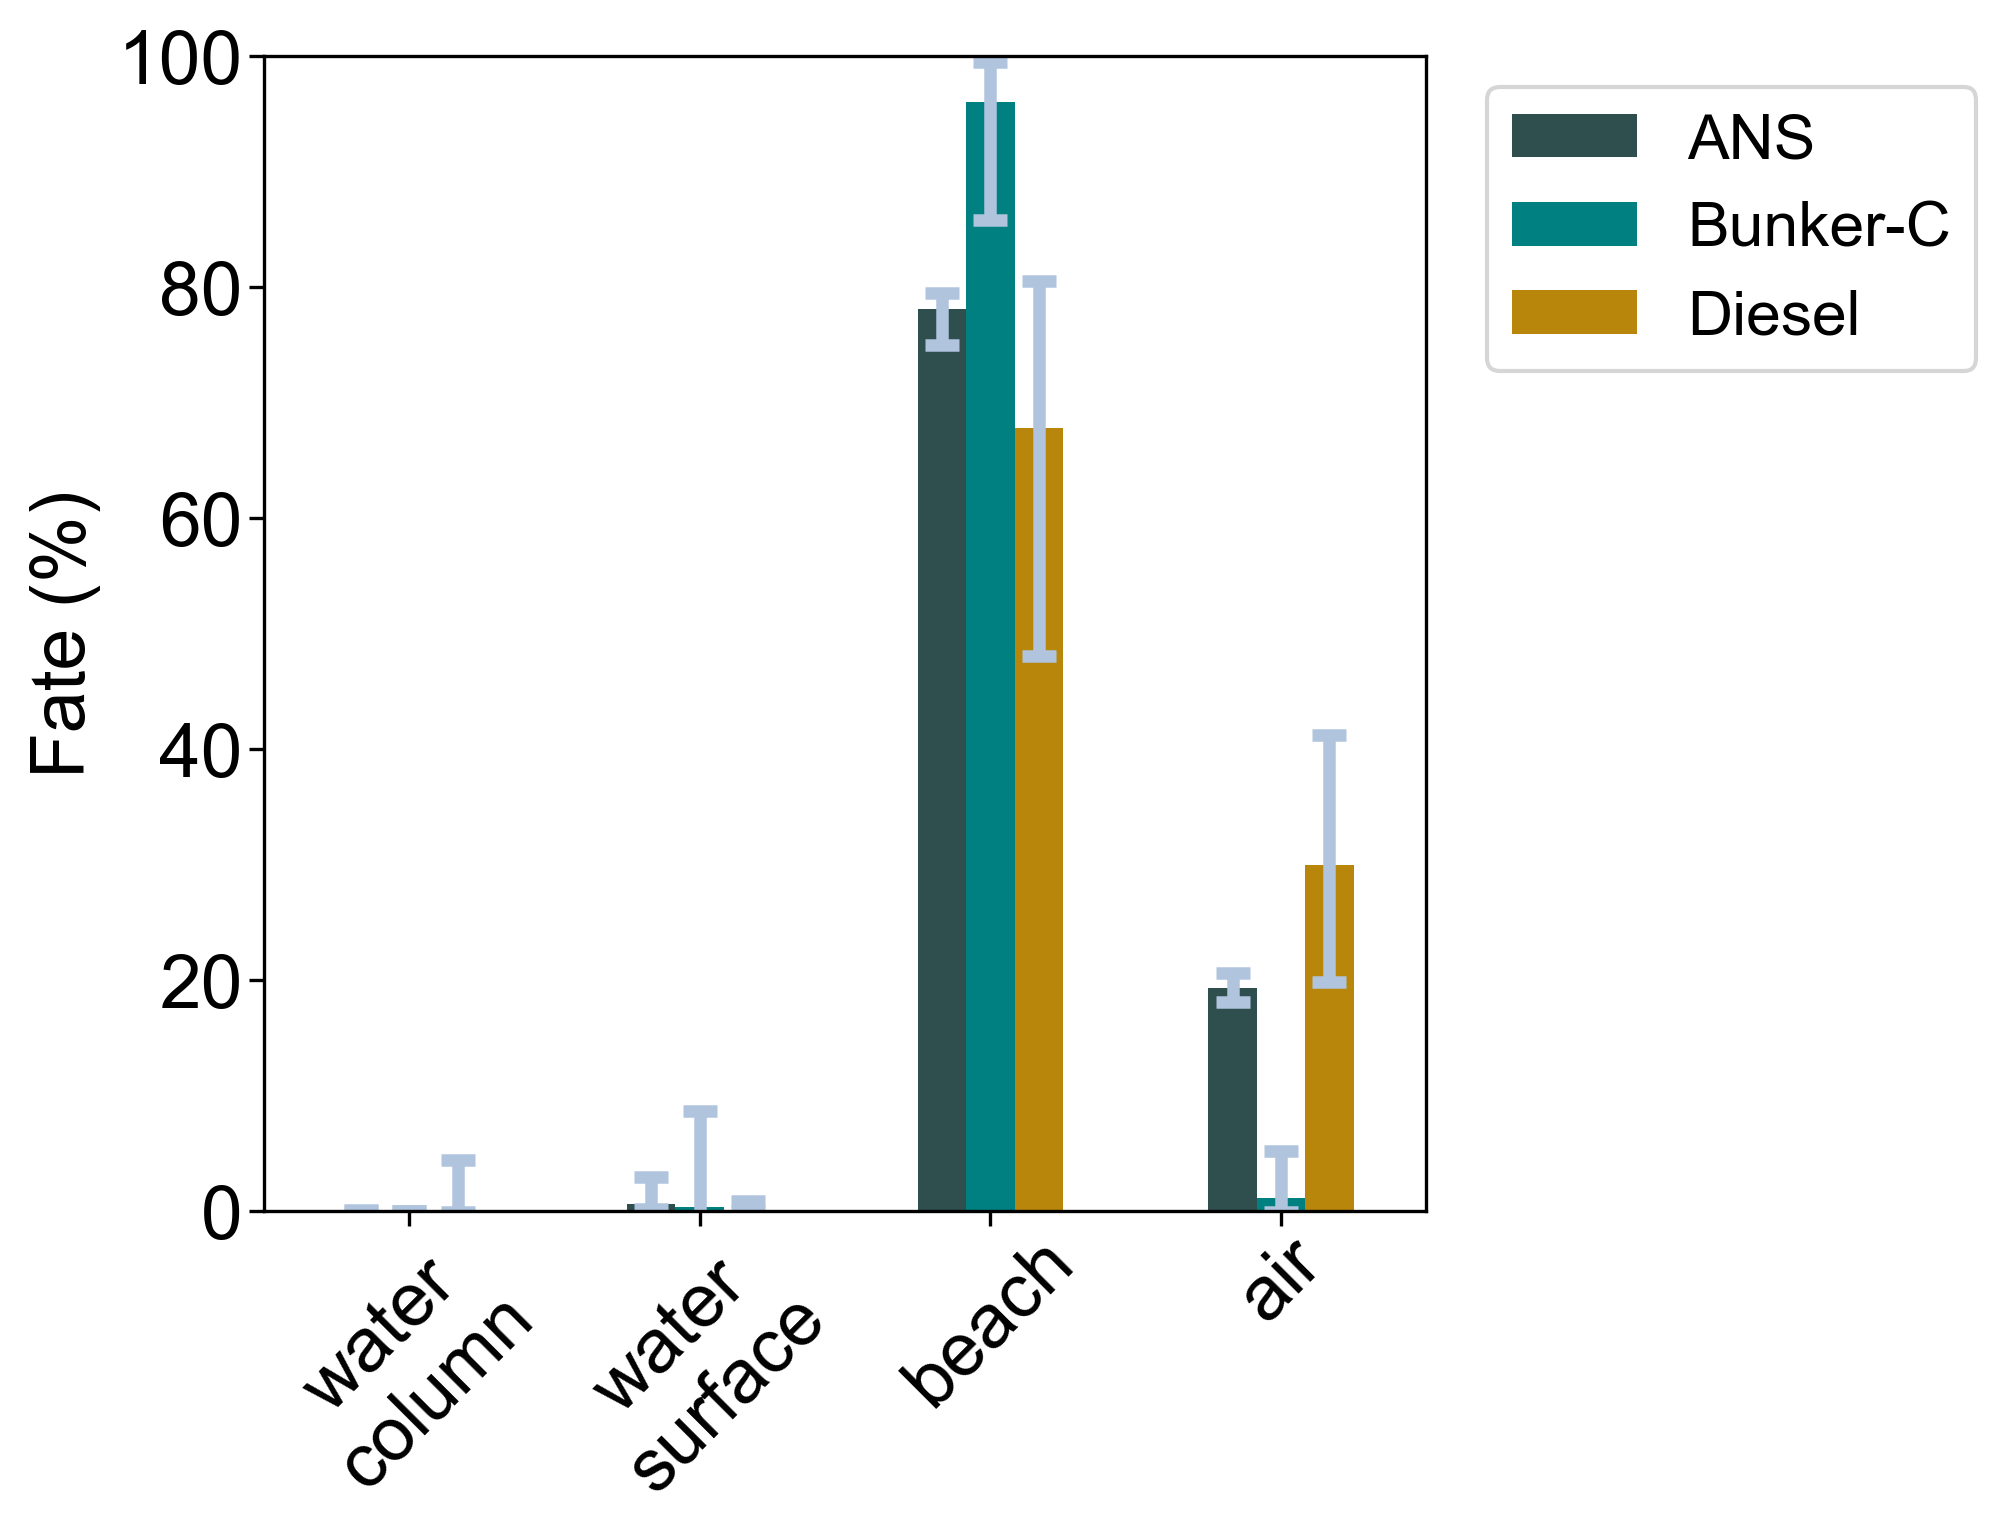

In [19]:
# bar colors
ans_color = graphics.oil_colors_dict["ANS"]
bunker_color = graphics.oil_colors_dict["Bunker-C"]
diesel_color = graphics.oil_colors_dict["Diesel"]


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1],
                       'wspace': 0.4,
                       'hspace': 0.2})
persist_df['median'].plot(ax=ax,
    kind="bar",
    color=[ans_color, bunker_color, diesel_color],
    legend=False,          
    yerr=yerr_reorg, 
    error_kw=dict(lw=3, capsize=4, capthick=3),
    ecolor='lightsteelblue'
)
ax.set_ylabel("Fate (%)")
ax.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
ax.set_ylim(0,100)
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xticklabels(
    ["water\ncolumn", "water\nsurface", "beach", "air"],
    rotation=45
)

plt.savefig(graphics_dir/'Part2_Figure3_Fate_MedianErr.png')